In [41]:
!python --version

Python 3.5.6 :: Anaconda, Inc.


In [17]:
from matplotlib import pyplot as plt
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.preprocessing import StandardScaler

In [18]:
df = pd.read_parquet("data/xgboost_raw_data_ypred.parquet")

In [20]:
df.describe()

,bookingID,count,label,y_pred
count,1.986300e+04,19863.000000,19863.000000,19863.000000
mean,8.166064e+11,612.855107,0.249257,0.083975
std,4.943443e+11,375.880335,0.432594,0.277358
min,0.000000e+00,1.000000,0.000000,0.000000
25%,3.865471e+11,323.000000,0.000000,0.000000
50%,7.988639e+11,544.000000,0.000000,0.000000
75%,1.245541e+12,839.000000,0.000000,0.000000
max,1.709397e+12,4361.000000,1.000000,1.000000


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19863 entries, 3333 to 12603
Data columns (total 4 columns):
bookingID    19863 non-null int64
count        19863 non-null int64
label        19863 non-null float64
y_pred       19863 non-null int64
dtypes: float64(1), int64(3)
memory usage: 775.9 KB


In [31]:
df['label']  = df['label'].astype('int64')

In [37]:
# the count descriptive for label 0 summary
df[df.label == 0]['count'].describe()

count    14912.000000
mean       577.826046
std        338.974198
min          1.000000
25%        312.000000
50%        516.000000
75%        790.000000
max       2226.000000
Name: count, dtype: float64

In [38]:
# the count descriptive for label 1 summary
df[df.label == 1]['count'].describe()

count    4951.000000
mean      718.359725
std       453.825184
min         1.000000
25%       369.000000
50%       650.000000
75%       988.000000
max      4361.000000
Name: count, dtype: float64

In [34]:
# false positive
fp_df = df[(df.y_pred == 1) & (df.label == 0)]

In [36]:
fp_df['count'].describe()

count     157.000000
mean      729.152866
std       526.826349
min        23.000000
25%       215.000000
50%       637.000000
75%      1147.000000
max      2226.000000
Name: count, dtype: float64

In [39]:
# false negative
fn_df = df[(df.y_pred == 0) & (df.label == 1)]

In [40]:
fn_df['count'].describe()

count    3440.000000
mean      619.276163
std       338.631429
min         1.000000
25%       356.000000
50%       579.500000
75%       843.000000
max      2127.000000
Name: count, dtype: float64

In [44]:
# Load preprocessed file
with h5py.File('data/Xpad.h5', 'r') as hf:
    Xpad = hf['Xpad'][:]

In [45]:
df_label = pd.read_parquet("data/bookingID.parquet")

In [52]:
df_label.head()

,bookingID,count,label
index,,,
3333,0,981,0.0
8685,1,607,1.0
18906,2,133,1.0
2926,4,1023,1.0
8283,6,630,0.0


In [47]:
# reshape to 2d
num_timestep = Xpad.shape[1]
num_feature = Xpad.shape[2]
X = pd.DataFrame(Xpad.reshape(Xpad.shape[0], num_timestep*num_feature))

In [49]:
x_pca = StandardScaler().fit_transform(X)

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_pca)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [61]:
print("Components variance",pca.explained_variance_ratio_)
print("Total information persisted", pca.explained_variance_ratio_.sum())

Components variance [0.49934481 0.15855998]
Total information persisted 0.6579047837344145


In [53]:
pca_df = pd.concat([principalDf, df_label[['label']]], axis = 1)

CPU times: user 131 ms, sys: 23.4 ms, total: 154 ms
Wall time: 109 ms


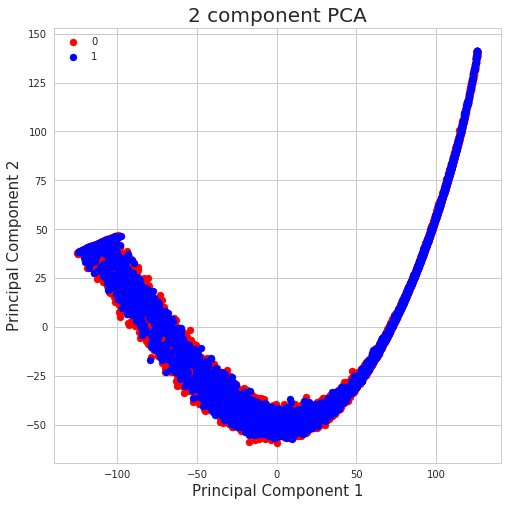

In [58]:
%%time
%matplotlib inline
plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0, 1]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indices = pca_df['label'] == target
    ax.scatter(pca_df.loc[indices, 'principal component 1']
               , pca_df.loc[indices, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
#ax.grid()